In [2]:
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Evaluation

이번 프로젝트의 워크플로우는 크게 2 종류로 구성되어 있습니다. 

평가를 그에 따라 아래와 같이 진행하였습니다. 

1. lite 워크플로우 평가
2. router 노드 평가
3. deep 워크플로우 평가 


### 1. Lite 워크플로우 평가
Lite 워크플로우는 최신성을 중점으로 평가하였습니다. 
Ko-freshqa 데이터 셋을 사용해 평가하였으며, 아래 주소에서 확인할 수 있습니다. 

평가 주소 :
https://huggingface.co/spaces/upstage/ko-freshqa-leaderboard


🔹 relaxed evaluation

- 답변이 가진 주요 정보의 정확성에만 초점을 맞춰 평가합니다.  
- 환각이나 오래된 정보가 포함되어 있어도, 주요 정보에 영향을 미치지 않으면 정답으로 인정될 수 있습니다.  
- 답변 형식이 잘못된 경우(예: 다른 언어로 답변)도 허용됩니다.  

🔹 strict evaluation

- 주요 정보의 정확성뿐 아니라, 모든 사실이 정확하고 최신이어야 합니다.  
- 사소한 환각이라도 포함되면 정답으로 인정되지 않습니다.  
- "제 지식은 2021년 9월까지입니다…" 같은 오래된 정보 경고 문구는 그 내용이 변경되지 않았음이 명확한 경우에만 정답으로 인정됩니다.  

### 1.1 Lite 워크플로우 평가 결과

Team3으로 제출하였으며, Accuracy 77.03 점을 달성하였습니다.

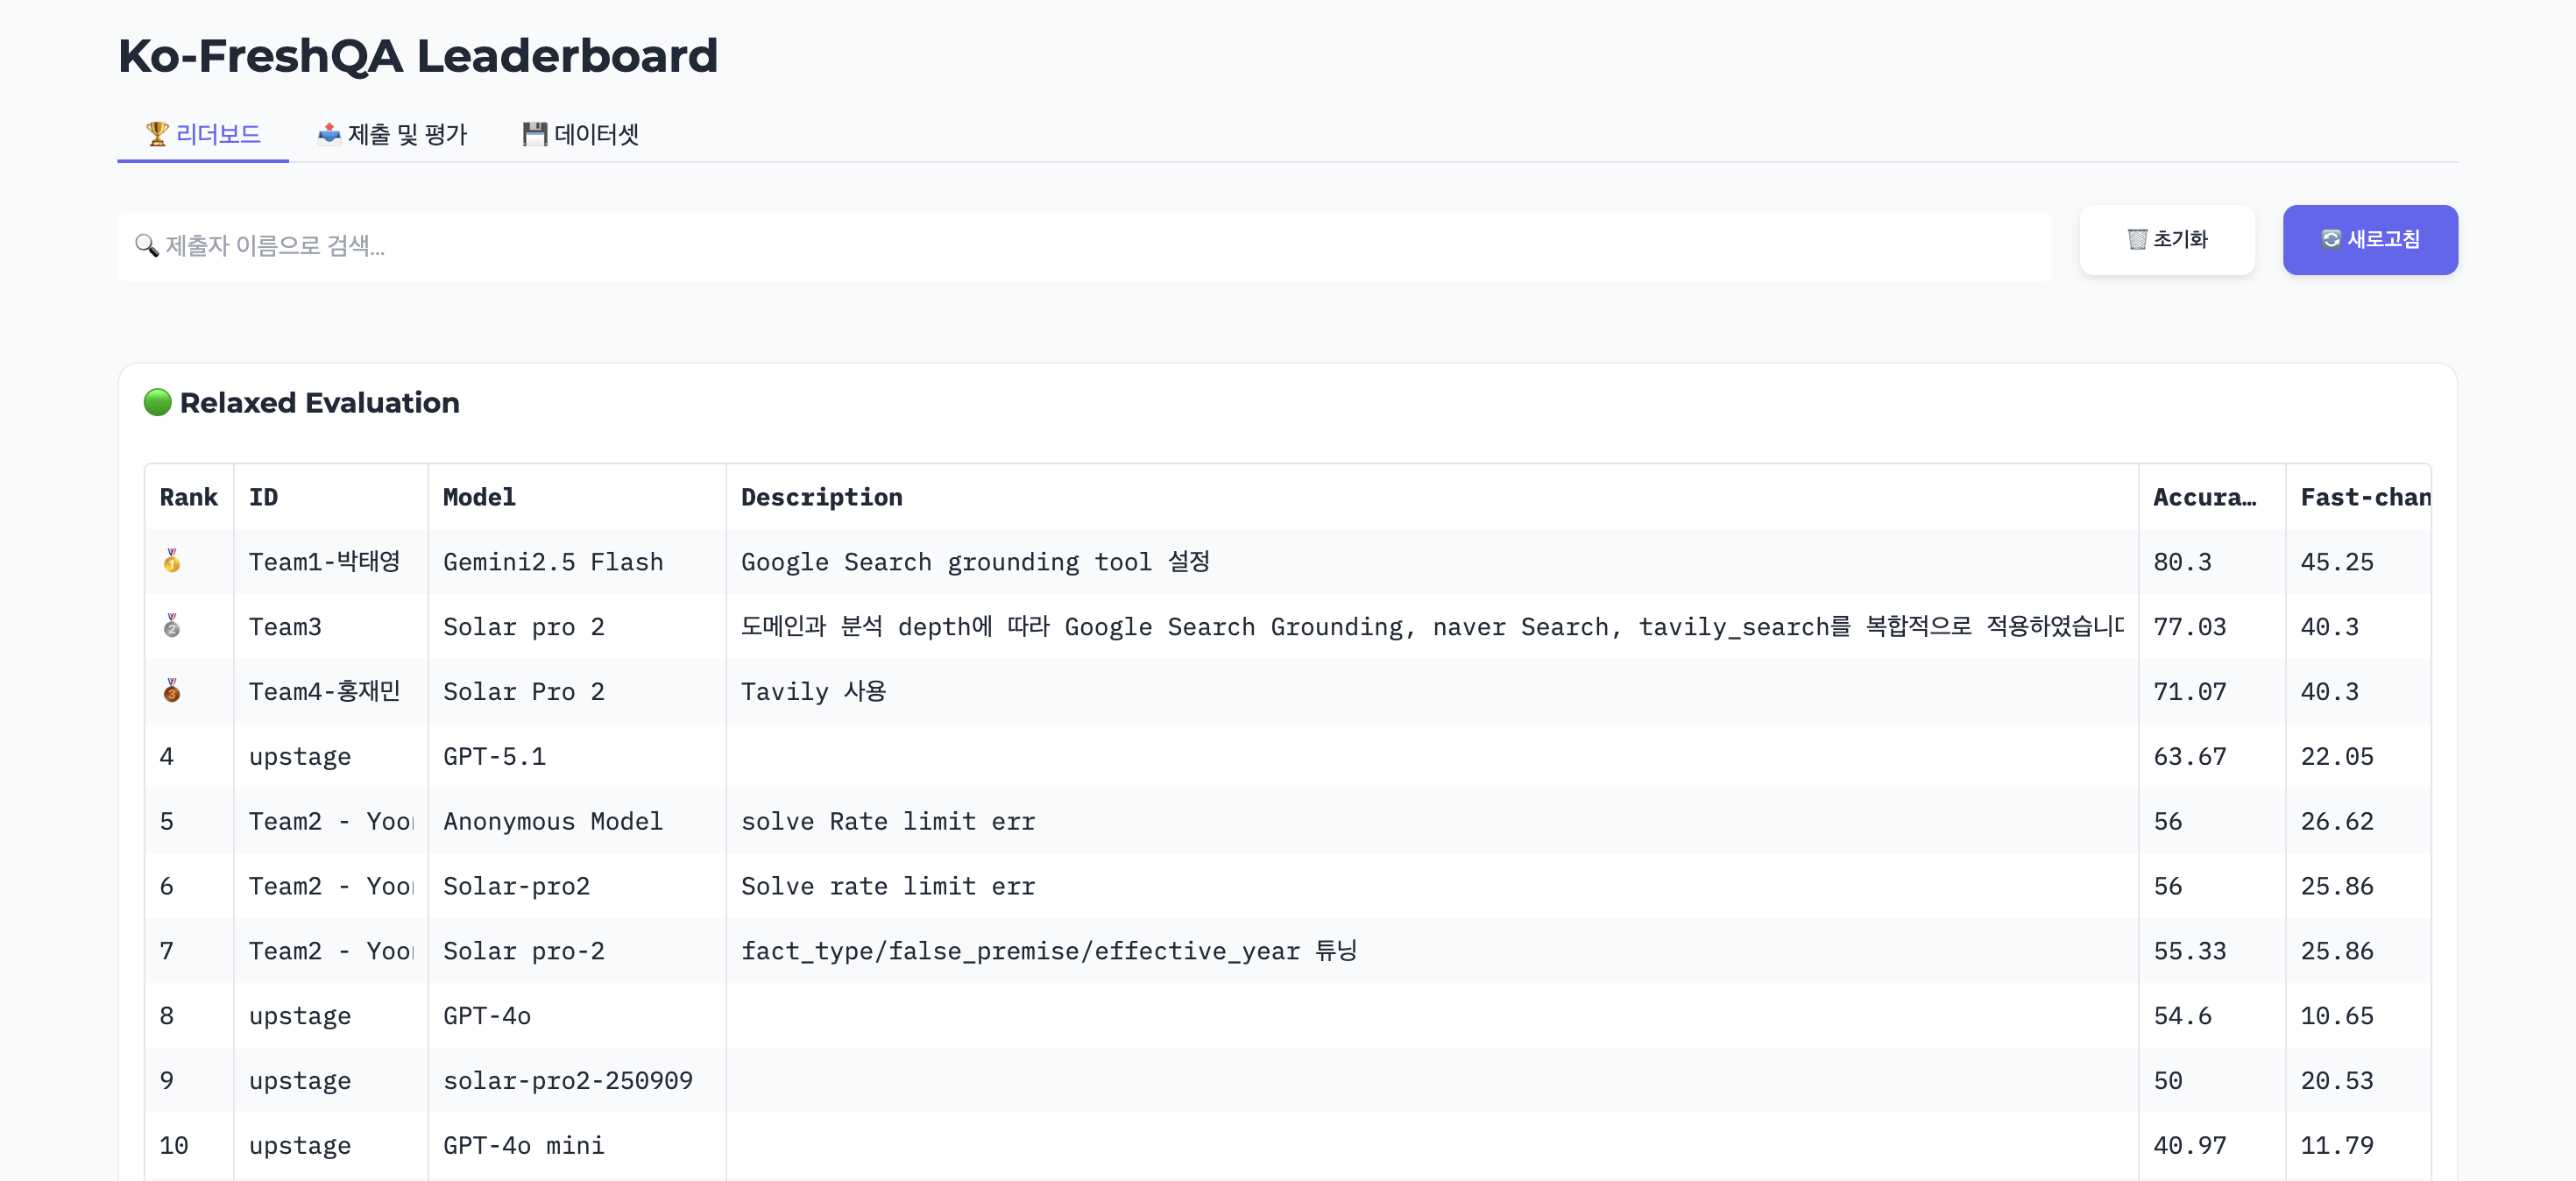

### 2. router 노드 평가

워크플로우가 질문에 따라 질문의 depth를 미리 파악하고, 질의가 단순하고 단일 검색으로 끝날 만한 것이라면,    
router 노드가 lite 워크플로우로 분기합니다. 그에 따라 문제를 정확히 이해하고 어느 정도의 추론이 필요한지 미리 파악하는 것이 중요합니다. 

ko-freshqa 데이터 셋과 deep 노드에서 사용할 만한 쿼리로 데이터 셋을 구성하고, 정확도를 측정하였습니다.    
또한 추론 이유도 함께 뽑아내어 왜 router가 그 노드로 분기시겼는지 확인하였습니다. 

### 3. Deep research 평가 
기존에는 최신성을 기준으로 한 Ko-FreshQA로 딥리서치 시스템을 평가하는 방안을 검토했지만, 이 방식만으로는 적합하지 않다고 판단했습니다.   
정보의 최신성 뿐만 아니라 서비스가 실제로 제공하려는 분석 내용과 범위를 얼마나 잘 커버하고 있는지까지 함께 평가할 수 있어야 합니다.   

이에 따라, 딥리서치 시스템의 특성을 반영할 수 있는 전용 데이터셋과 평가 지표를 직접 설계하고, 이를 이용해 시스템 성능을 평가했습니다.


### 3.1 Deep Research 평가 데이터셋

딥리서치 평가 데이터셋은 **정치인 단위 리포트**를 중심으로 구성하였습니다.    
평가 대상 정치인은 전 세계를 대상으로 선정했으며, **한국 대통령 및 유력 정치인 9명**과 **해외 주요 국가 정상 10명**을 포함하였습니다. 

각 정치인에 대해 ChatGPT 기반 Deep Research 워크플로우를 실행하여,

* 해당 정치인의

  * 핵심 정책,
  * 영향을 미치는 산업·섹터,
  * 관련 기업,
  * 정책–산업–기업 간 영향 관계
    를 정리한 **정치인별 영향 분석 리포트**를 수집하였습니다. 


### 3.2 Deep research 평가 지표

평가는 `evaluate_report_evidence`에 의해 이루어집니다.   
모델은 아래의 3개의 하위 워크플로우에서 평가합니다.

1. **Gold Report Alignment**

   * 우리가 목표로 삼은 Deep Research 스타일(Gold)과 구조·내용이 비슷한가?
   * 정책–산업–기업–영향 체인 구성과 요약 문단 수준에서의 일관성 평가

2. **Impact Evidence Faithfulness (할루시네이션 검증)**

   * 이 정치인·정책이 기업/산업에 이런 영향을 줬다는 설명이, 실제 기사 본문과 얼마나 잘 맞는가?
   * 기사 근거 기반 vs 모델 생성 내용을 직접 비교

3. **Policy Attribution Consistency (정책 귀속 관련성)**

   * 이 URL이 정말로 이 정치인과 이 정책에 관한 기사인가?
   * 모델의 검색/근거 선택이 정치·정책 맥락에 얼마나 맞는지 평가



---


#### 1. Gold Report Alignment (골드 리포트 정합성 평가)

> `model_report`가 `gold_report`와 **구조적으로, 내용적으로 얼마나 가까운지**를 평가합니다.

**무엇을 평가하는가?**

같은 정치인에 대해 다음 두 리포트를 비교합니다.

* ChatGPT Deep Research가 생성한 `gold_report`
* 우리 Deep Research 워크플로우가 생성한 `model_report`

이 두 리포트가 **정책–산업–기업–영향 관계 측면에서 얼마나 비슷한 구조와 내용을 가지는지**를 평가합니다.

**어떻게 평가하는가?**

하나의 LLM 노드에서 두 리포트를 함께 입력으로 넣고, 다음을 비교합니다.

* `question_answer` 수준에서
  → 두 리포트가 해당 정치인의 **핵심 정책 방향과 그로 인한 산업·기업 영향**을 유사하게 설명하고 있는지
* `influence_chains` 수준에서
  → 체인 단위로

  * 어떤 정책들이 등장하는지
  * 어떤 산업·섹터를 다루는지
  * 어떤 기업들이 언급되는지
  * 각 기업·섹터가 **수혜/피해, 성장/위축 등 어떤 방향의 영향을 받는 것으로 설명되는지**

이때 Gold는 **절대적인 정답 레이블**으로써 동작하기보다는 내용과 구조가 얼마나 유사한가를 확인할 수 있습니다. 


---

#### 2. Impact Evidence Faithfulness

> 딥리서치 워크플로우의 리포트가 할루시네이션인지, 근거에 기반한 설명인지를 평가합니다.    



**무엇을 평가하는가?**

각 `influence_chain`에 대해,

* `impact_description`
  → “이 정책이 특정 산업/기업에 어떤 경제적 영향을 줬다”는 모델의 주장 문장
* 해당 체인에 연결된 evidence URL에서 스크래핑한 기사 본문(`source`)

을 비교하여,

> 이 영향 설명이 실제 기사 내용에 의해 지지되는지,   
> 아니면 기사에 없는 내용을 할루시네이션한 것인지

를 평가합니다.


이때 하나의 `impact_description`을 생성하기 위해 여러 개의 evidence URL이 연결될 수 있습니다.
그 이유는 다음과 같습니다.

1. 단일 기사(단일 URL)에서 특정 정책–산업–기업이 모두 동시에 언급되는 경우는 많지 않습니다.
2. 하나의 기사만으로 사실성을 판단하기보다는, 여러 출처를 종합해서 하나의 영향 설명을 구성하는 편이 서비스의 설계 의도와 잘 들어맞기 때문입니다.


**어떻게 평가하는가?**

`impact_evidence_faithfulness` 워크플로우는 다음과 같이 동작합니다.

1. `scrape_urls_node`

   * 각 evidence URL에 접속해 기사 텍스트를 수집합니다.

2. `evaluate_impact_node`

   * URL별로 LLM에 다음 정보를 전달합니다.

     * `industry_or_sector`
     * `companies`
     * `impact_description`
     * `source` (기사 본문)
     * `question`
   * LLM은 **기사 내용 vs 영향 설명**을 비교해 다음 라벨 중 하나를 반환합니다.

     * `SUPPORTED`
     * `PARTIALLY_SUPPORTED`
     * `UNSUPPORTED`
     * `CONTRADICTED`
     * `NOT_ENOUGH_INFO`
   * 함께

     * `score` (0.0–1.0)
     * `reasoning` (한국어 설명)
     * 기사 본문에서 뽑은 `evidence_spans`(관련 문장들)
       를 제공합니다.

**이 단계가 측정하는 것**

* **할루시네이션 여부**

  * `SUPPORTED / PARTIALLY_SUPPORTED` 비율이 높을수록
    → 모델이 기사 근거 범위 내에서 합리적인 영향 설명을 하고 있다는 뜻
  * `UNSUPPORTED / CONTRADICTED` 비율이 높을수록
    → 기사에 없는 내용, 혹은 기사와 반대되는 내용을 생성하고 있다는 신호

* 또한, **영향 설명의 디테일**
  (수치, 방향성, 수혜/피해 여부 등)가 기사와 **얼마나 정밀하게 일치하는지**를 직접적으로 측정합니다.

---

| 라벨                    | 의미                                          | 점수 예시 (score) | 시스템 해석                       |
| --------------------- | ------------------------------------------- | ------------- | ---------------------------- |
| `SUPPORTED`           | 기사 본문이 `impact_description`의 핵심 내용을 명확히 지지함 | 0.8–1.0       | **근거에 매우 충실한 영향 설명**         |
| `PARTIALLY_SUPPORTED` | 일부 내용은 지지되지만, 일부는 기사에 없거나 모호함               | 0.4–0.8       | **부분적으로 근거 있음 (보수적 신뢰)**     |
| `UNSUPPORTED`         | 기사에서 해당 영향 설명을 뒷받침하는 근거를 찾기 어려움             | 0.0–0.4       | **근거가 거의 없는 주장 → 할루시네이션 의심** |
| `CONTRADICTED`        | 기사 내용이 오히려 영향 설명과 반대 방향을 시사함                | 0.0–0.4       | **기사와 상충하는 잘못된 설명**          |
| `NOT_ENOUGH_INFO`     | 기사 길이/정보가 부족해 판단이 불가능                       | 사용하지 않음       | **평가에서 제외(스코어/분포 계산에서 필터링)** |


#### 3. Policy Attribution Consistency

> 정치인과 정책 관련성을 평가합니다.   

**무엇을 평가하는가?**

각 `influence_chain`에 대해,

* 지정된 `politician` + `policy`
* 해당 체인의 evidence URL에서 가져온 기사

사이의 **정치·정책 관련성**을 평가합니다.

> “이 URL은 정말 이 정치인의 이 정책과 관련된 기사인가?”
> “아니면 단지 산업/기업 이름만 같을 뿐, 정책·정치 맥락은 거의 없는 기사인가?”

를 판별하는 단계입니다.

**어떻게 평가하는가?**

`policy_attribution_consistency` 워크플로우는 다음 순서로 동작합니다.

1. URL 스크래핑

   * `scrape_urls_node`에서 Impact 평가와 동일하게 기사 텍스트를 수집합니다. (공유 노드)

2. `evaluate_policy_attribution_node`

   * 각 URL별로 LLM에 다음 정보를 전달합니다.

     * `politician`, `policy`
     * `industry_or_sector`, `companies`
     * `source_title`, `url`, `source`
   * LLM은 기사와 (politician, policy)의 관계를 평가해 다음을 반환합니다.

     * `label`

       * `HIGHLY_RELATED`
       * `WEAKLY_RELATED`
       * `UNRELATED`
       * `NOT_ENOUGH_INFO`
     * `score` (0.0–1.0)
     * `politician_mentioned`
       → 기사에서 해당 정치인이 **실질적으로 등장하는지 여부**
     * `policy_topic_mentioned`
       → 정책 자체 또는 핵심 주제(예: 원전 확대, AI 예산, 금산분리 등)가 **중요하게 다뤄지는지 여부**
     * `evidence_spans` (관련 구문들)

**이 단계가 측정하는 것**

* **검색/증거 선택 품질**

  * 모델이 가져온 URL이 정말 해당 **정치인·정책 맥락의 기사**인지,
  * 아니면 그저 “같은 기업 이름이 잠깐 등장하는 기사”인지를 구분합니다.

* 결과적으로, 이 평가는

  * 딥리서치 시스템이 **정책·정치 맥락에 적절한 근거 기사**를 잘 선택하고 있는지,
  * 특정 정치인에게 **관련 없는 정책·영향을 억지로 귀속시키고 있지는 않은지**
    를 검증하는 역할을 합니다.



| 라벨                | 의미                                | score 예시 | Retrieval 평가 관점 해석                     |
| ----------------- | --------------------------------- | -------- | -------------------------------------- |
| `HIGHLY_RELATED`  | 기사 내용이 해당 정치인과 정책을 **핵심 주제로 다룸**  | 0.8–1.0  | **매우 적절한 근거 기사 (이상적 검색 결과)**           |
| `WEAKLY_RELATED`  | 정치인 또는 정책이 부분적으로 언급되지만, 비중이 크지 않음 | 0.4–0.8  | **보조 근거로는 사용 가능하나, 핵심 근거로는 약함**        |
| `UNRELATED`       | 기업/산업만 등장하거나, 정치인·정책과 실질적 연결이 없음  | 0.0–0.4  | **잘못 검색된 기사 (검색/증거 선택 품질 저하)**         |
| `NOT_ENOUGH_INFO` | 텍스트가 짧거나 애매해서 관련성을 판단하기 어려움       | 사용 안 함   | **평가/집계에서 제외 (retrieval 품질 분석 대상 아님)** |


### 3.3 Deep research 평가 함수

`evaluate_report_evidence` 함수는 단일 리포트(하나의 정치인에 대한 Deep Research 결과)에 대해  
다음 세 가지 평가를 수행하고 결과를 통합합니다.   

1. **Impact Evidence Faithfulness**  
   - 체인별(`influence_chain` 단위)로  
     `impact_description`이 연결된 기사 evidence에 의해 얼마나 지지되는지 평가합니다.   

2. **Policy Attribution Consistency**  
   - 체인별로  
     해당 evidence URL이 정말로 지정된 `politician` + `policy`와 관련된 기사인지 평가합니다.   

3. **Gold Report Alignment (옵션)**  
   - `gold_report`가 주어진 경우, 리포트 전체 수준에서  
     `model_report`가 Gold 리포트와 구조·내용 면에서 얼마나 유사한지 평가합니다.   

---



In [3]:
from eval_graph import CombinedEvalState, combined_eval_app
from typing import Dict, Any, List, Optional


async def evaluate_report_evidence(
    model_report: Dict[str, Any],
    gold_report: Optional[Dict[str, Any]] = None,
    question: Optional[str] = None,
) -> Dict[str, Any]:
    """
    Run:
    - Impact Evidence Faithfulness (per-chain, multi-source)
    - Policy Attribution Consistency (per-chain, multi-source)
    - (optionally) Gold vs Model report comparison
    """
    question_for_gold = question or model_report.get("question_answer", "") or ""
    chains = model_report.get("influence_chains", [])

    all_chain_results: List[Dict[str, Any]] = []
    gold_eval: Optional[Dict[str, Any]] = None

    for idx, chain in enumerate(chains):
        # 1) 체인별 state 구성
        chain_state: CombinedEvalState = {
            "politician": chain.get("politician"),
            "policy": chain.get("policy"),
            "industry_or_sector": chain.get("industry_or_sector"),
            "companies": chain.get("companies"),
            "impact_description": chain.get("impact_description"),
            "question": question_for_gold,
            "evidence": chain.get("evidence", []),
        }

        # 2) gold vs model 비교는 질문/리포트 전체 기준이므로
        if gold_report is not None:
            chain_state["gold_report"] = gold_report
            chain_state["model_report"] = model_report

        # 3) 그래프 실행
        print(f"[DEBUG] politiocian: {chain_state['politician']}, policy: {chain_state['policy']}")
        result_state = await combined_eval_app.ainvoke(chain_state)

        # 4) 체인별 결과 수집 (per-chain 단일 결과를 기대)
        impact_result = result_state.get("impact_result")
        attribution_result = result_state.get("attribution_result")

        # BaseModel이면 dict로 변환
        if hasattr(impact_result, "model_dump"):
            impact_result = impact_result.model_dump()
        if hasattr(attribution_result, "model_dump"):
            attribution_result = attribution_result.model_dump()

        all_chain_results.append(
            {
                "chain_index": idx,
                "politician": chain.get("politician"),
                "policy": chain.get("policy"),
                "industry_or_sector": chain["industry_or_sector"],
                "companies": chain["companies"],
                "impact_description": chain["impact_description"],
                "impact_result": impact_result,
                "attribution_result": attribution_result,
            }
        )

        # gold_eval 은 리포트 전체 기준이므로 한 번만 담기
        if gold_report is not None and gold_eval is None:
            gold_eval = result_state.get("gold_eval")
            if hasattr(gold_eval, "model_dump"):
                gold_eval = gold_eval.model_dump()
        

    return {
        "chain_results": all_chain_results,
        "gold_eval": gold_eval,
    }


#### 워크플로우 불러오기
평가에 사용할 워크플로우를 불러옵니다. 

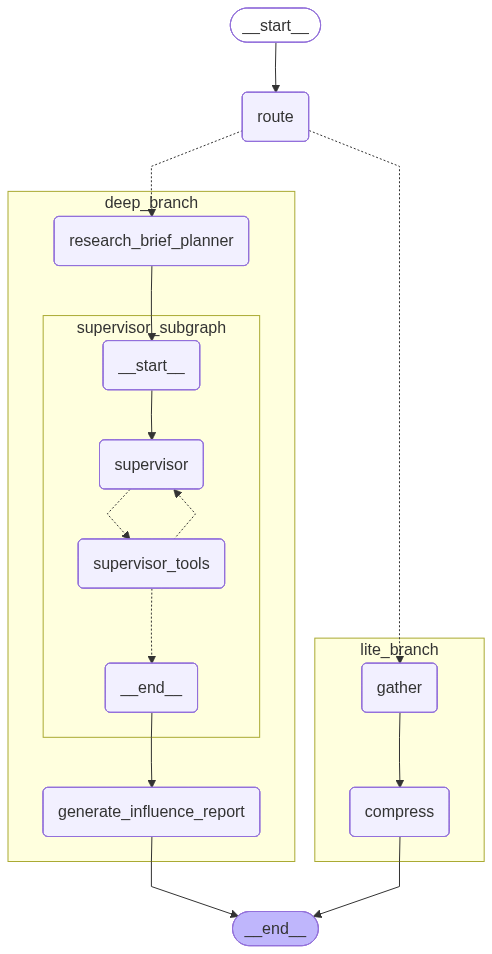

In [4]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research.router import router_builder

checkpointer = InMemorySaver()
full_agent = router_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=-1).draw_mermaid_png()))

#### 워크플로우 실행
워크플로우를 실행하여 테스트셋에 대한 평가용 데이터셋을 생성합니다.   

In [5]:
import json
from pathlib import Path
from typing import Any, Dict
from uuid import uuid4

from langchain_core.messages import HumanMessage


def extract_model_response(result: Dict[str, Any]) -> Dict[str, Any]:
    """
    Extract the structured final_report object from the agent result.
    """
    final_report = result.get("final_report")
    if isinstance(final_report, dict):
        return final_report
    # Fallback: just wrap as dict
    return {"final_report_raw": final_report}


async def generate_model_responses_for_influence(
    gold_jsonl_path: str = "../dev_test/influence_gold.jsonl",
    output_jsonl_path: str = "../dev_test/influence_model_responses_3.jsonl",
    base_thread_id: str = "influence",
) -> None:
    """
    For each line in influence_gold.jsonl:
      - read {"question": "...", "gold_report": {...}}
      - call full_agent with that question
      - extract final_report
      - write {"query": question, "gold_report": ..., "model_response": ...} to output JSONL.

    If output_jsonl already has some entries, skip those queries and only run for the remaining ones.
    """
    gold_path = Path(gold_jsonl_path)
    out_path = Path(output_jsonl_path)

    if not gold_path.exists():
        raise FileNotFoundError(f"Gold file not found: {gold_path}")


    processed_queries: set[str] = set()
    if out_path.exists():
        with out_path.open("r", encoding="utf-8") as f_in:
            for line in f_in:
                line = line.strip()
                if not line:
                    continue
                try:
                    rec = json.loads(line)
                except json.JSONDecodeError:
                    continue
                q = rec.get("query")
                if isinstance(q, str):
                    processed_queries.add(q)

    print(f"[INFO] Already processed {len(processed_queries)} queries")

    with gold_path.open("r", encoding="utf-8") as fin, \
         out_path.open("a", encoding="utf-8") as fout:

        for idx, line in enumerate(fin):
            line = line.strip()
            if not line:
                continue

            record = json.loads(line)
            question = record.get("question")
            if not question:
                continue

            # 이미 처리된 query면 스킵
            if question in processed_queries:
                print(f"[SKIP] already processed query: {question}")
                continue

            thread_config = {
                "configurable": {
                    "thread_id": f"{base_thread_id}-{idx}-{uuid4()}",
                    "recursion_limit": 50,
                }
            }

            print(f"[RUN] query={question} (idx={idx})")

            result = await full_agent.ainvoke(
                {"messages": [HumanMessage(content=question)]},
                config=thread_config,
            )

            model_report = extract_model_response(result)

            out_obj = {
                "query": question,
                "gold_report": record.get("gold_report"),
                "model_response": model_report,
            }

            fout.write(json.dumps(out_obj, ensure_ascii=False) + "\n")
            fout.flush()


await generate_model_responses_for_influence()


[INFO] Already processed 19 queries
[SKIP] already processed query: 윤석열
[SKIP] already processed query: 이재명
[SKIP] already processed query: 문재인
[SKIP] already processed query: 박근혜
[SKIP] already processed query: 이명박
[SKIP] already processed query: 홍준표
[SKIP] already processed query: 안철수
[SKIP] already processed query: 이준석
[SKIP] already processed query: 심상정
[SKIP] already processed query: Joe Biden
[SKIP] already processed query: Donald Trump
[SKIP] already processed query: Xi Jinping
[SKIP] already processed query: Vladimir Putin
[SKIP] already processed query: Narendra Modi
[SKIP] already processed query: Rishi Sunak
[SKIP] already processed query: Emmanuel Macron
[SKIP] already processed query: Volodymyr Zelensky
[SKIP] already processed query: Fumio Kishida
[SKIP] already processed query: Mohammed bin Salman


#### 리포트 평가 함수

In [6]:
import json
import asyncio
from pathlib import Path
from typing import Set

async def evaluate_influence_reports(
    input_jsonl_path: str = "../dev_test/influence_model_responses_3.jsonl",
    output_jsonl_path: str = "../dev_test/influence_model_responses_eval_3.jsonl",
) -> None:
    """
    input_jsonl_path:
      각 줄이
      {
        "query": "...",
        "gold_report": {...},
        "model_response": {...}
      }
      형태인 JSONL 파일.

    output_jsonl_path:
      각 줄이
      {
        "query": "...",
        "evaluation": {...}
      }
      형태인 JSONL 파일.
      이미 존재하면, 기존에 평가된 query는 스킵하고
      새 query만 append 한다.
    """

    in_path = Path(input_jsonl_path)
    out_path = Path(output_jsonl_path)

    if not in_path.exists():
        raise FileNotFoundError(f"Input file not found: {in_path}")

    # 1) 이미 평가된 query 읽어서 set에 저장
    processed_queries: Set[str] = set()
    if out_path.exists():
        with out_path.open("r", encoding="utf-8") as f_out_read:
            for line in f_out_read:
                line = line.strip()
                if not line:
                    continue
                try:
                    rec = json.loads(line)
                except json.JSONDecodeError:
                    continue
                q = rec.get("query")
                if isinstance(q, str):
                    processed_queries.add(q)

    print(f"[INFO] already processed {len(processed_queries)} queries")

    # 2) output은 append 모드로 열기 (새로운 평가 결과 추가)
    with in_path.open("r", encoding="utf-8") as fin, \
         out_path.open("a", encoding="utf-8") as fout:

        for idx, line in enumerate(fin):
            line = line.strip()
            if not line:
                continue

            record = json.loads(line)

            query = record.get("query")
            gold_report = record.get("gold_report")
            model_report = record.get("model_response")

            print(f"[DEBUG] Processing line {idx}, query={query}")
            print(f"[DEBUG] Gold report keys: {gold_report}")
            print(f"[DEBUG] Model report keys: {model_report}")
            

            if not query or not gold_report or not model_report:
                print(f"[WARN] line {idx}: missing fields, skipping")
                continue

            # 이미 평가한 query면 스킵
            if query in processed_queries:
                print(f"[SKIP] already evaluated query: {query}")
                continue
            
            # 평가 함수 호출
            result = await evaluate_report_evidence(
                model_report=model_report,
                gold_report=gold_report,
                question=query,
            )

            out_record = {
                "query": query,
                "evaluation": result,
            }

            fout.write(json.dumps(out_record, ensure_ascii=False) + "\n")
            fout.flush()

            if (idx + 1) % 10 == 0:
                print(f"[INFO] processed {idx + 1} lines")

    print(f"[DONE] saved eval JSONL to {out_path}")


In [7]:
await evaluate_influence_reports()

[INFO] already processed 18 queries
[DEBUG] Processing line 0, query=윤석열
[DEBUG] Gold report keys: {'report_title': '윤석열 전 대통령의 정치·경제 영향력 네트워크 분석', 'time_range': '2025년 11월 24일 기준', 'question_answer': '윤석열 전 대통령은 원전 확대 정책으로 두산에너빌리티와 한국전력 등 원전 관련 기업에 수혜를 주었으며, 동시에 원전 중심 기조는 한화솔루션의 태양광 사업에 부정적 영향을 미쳤습니다. 또한 국방비 증액과 기술 육성 정책으로 방산 및 첨단산업 기업의 성장에 기여했으며, 미국·일본과의 동맹 강화 및 중동 경제협력 확대를 통해 국제적 영향력을 도모했습니다.', 'influence_chains': [{'politician': '윤석열', 'policy': '원전 확대 정책', 'industry_or_sector': '에너지/원전', 'companies': ['두산에너빌리티'], 'impact_description': '윤석열 정부가 신한울 3·4호기 건설 등 원전 사업을 재개하면서 두산에너빌리티가 원전 주기기 제작 수주와 SMR 기술 개발 지원을 받는 등 직접적 수혜를 입었습니다:contentReference[oaicite:0]{index=0}. 글로벌 에너지 위기 속 원전 수요 증가로 해당 기업의 재무 실적도 개선되었습니다.', 'evidence': [{'source_title': '윤석열 정책 수혜주 2편] 전 두산중공업(현 두산에너빌리티), 친원전 ...', 'url': 'https://contents.premium.naver.com/richplatform/therichplatform/contents/220416185027884GB'}]}, {'politician': '윤석열', 'policy': '원전 중심 에너지정책', 'industry_or_sector': '신재생에너지/태양광', 'companies':

I0000 00:00:1764996303.363160 2644040 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764996303.381748 2644040 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[DEBUG] politiocian: Volodymyr Zelensky, policy: EU 통합 노력


I0000 00:00:1764996326.387826 2644040 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


[DEBUG] politiocian: Volodymyr Zelensky, policy: 반부패 개혁


I0000 00:00:1764996348.469913 2644040 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1764996348.479672 2644040 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


gold_eval : : : {'similarity_score': 0.4, 'reasoning': "두 보고서는 볼로디미르 젤렌스키의 정치·경제적 영향력을 분석하며 '반부패 개혁' 정책과 'DTEK' 기업을 공통적으로 언급합니다. 그러나 gold_report는 서방 군사지원으로 인한 방위산업 특수와 우크라이나 재건 사업에 초점을 맞춰 정책과 기업 간의 연관성 및 경제적 파급 효과를 구체적으로 설명하는 반면, model_report는 젤렌스키의 미디어/엔터테인먼트 산업 배경과 EU 통합 노력을 주요 내용으로 다루며 일부 정책의 경제적 영향 설명이 부족합니다.", 'model_unique_points': ['젤렌스키의 과거 미디어/엔터테인먼트 산업(Kvartal 95, 1+1 Media) 활동 및 올리가르히와의 연관성.', 'EU 통합 노력이 우크라이나 에너지 산업에 미치는 영향.'], 'gold_unique_points': ['서방 군사지원 외교를 통한 글로벌 방위산업(Lockheed Martin, BAE Systems)의 경제적 영향.', 'PrivatBank 국유화 및 올리가르히(Metinvest) 견제를 포함한 금융/철강 부문의 반부패·재벌 개혁.', '전력·농업 인프라 복구 및 우크라이나 재건 계획(Bechtel)을 통한 건설/전력 산업의 활성화.']}
[DEBUG] Processing line 17, query=Fumio Kishida
[DEBUG] Gold report keys: {'report_title': '기시다 후미오 일본 총리의 정치·경제 영향력 네트워크 분석', 'time_range': '2021–2025년 11월 24일 기준', 'question_answer': "기시다 총리는 방위비를 대폭 증액하여 미쓰비시중공업 등 방산기업에 새로운 성장 기회를 제공했고, 핵심전략산업(반도체·배터리)에 보조금을 지급하여 일본 기업의 국내 투자와 TSMC 등의 유치를 이끌었습니다. 또한 '새로운 자본주의' 기치 하에 기업들에 임금 인상과 투자 확대를 독려

### 평가 결과 파싱 함수

In [12]:
import json
from pathlib import Path
from typing import Any, Dict, List, Optional
from collections import Counter


def _is_valid_evidence_item(item: Dict[str, Any]) -> bool:
    """
    Return True if this evidence item should be used for scoring.
    Filters out:
      - NOT_ENOUGH_INFO labels
    """
    label = item.get("label")
    if label == "NOT_ENOUGH_INFO":
        return False
    return True


def extract_scores_from_record(record: Dict[str, Any]) -> Dict[str, Any]:
    """
    Given a single JSON record like:
      { "query": "...", "evaluation": { ... } }

    Return:
      {
        "impact_scores": [...],
        "impact_labels": [...],
        "attribution_scores": [...],
        "attribution_labels": [...],
        "gold_score": float | None
      }
    """
    evaluation = record.get("evaluation", {}) or {}
    chain_results: List[Dict[str, Any]] = evaluation.get("chain_results", []) or []

    impact_scores: List[float] = []
    impact_labels: List[str] = []
    attribution_scores: List[float] = []
    attribution_labels: List[str] = []

    for chain in chain_results:
        # -------- Impact Evidence --------
        impact_item = chain.get("impact_result") or {}
        if isinstance(impact_item, dict) and _is_valid_evidence_item(impact_item):
            score = impact_item.get("score")
            label = impact_item.get("label")

            if isinstance(score, (int, float)):
                impact_scores.append(float(score))
            if isinstance(label, str):
                impact_labels.append(label)

        # -------- Policy Attribution --------
        attr_item = chain.get("attribution_result") or {}
        if isinstance(attr_item, dict) and _is_valid_evidence_item(attr_item):
            score = attr_item.get("score")
            label = attr_item.get("label")

            if isinstance(score, (int, float)):
                attribution_scores.append(float(score))
            if isinstance(label, str):
                attribution_labels.append(label)

    gold_eval = evaluation.get("gold_eval", {}) or {}
    gold_score = gold_eval.get("similarity_score")
    if not isinstance(gold_score, (int, float)):
        gold_score = None

    return {
        "impact_scores": impact_scores,
        "impact_labels": impact_labels,
        "attribution_scores": attribution_scores,
        "attribution_labels": attribution_labels,
        "gold_score": gold_score,
    }


def _mean(xs: List[float]) -> Optional[float]:
    return sum(xs) / len(xs) if xs else None


def _is_domestic_query(query: str) -> bool:
    """
    query 안에 한글(가~힣)이 하나라도 포함되어 있으면 국내로 간주.
    """
    return any("가" <= ch <= "힣" for ch in query)


def compute_averages_from_jsonl_by_region(path: str) -> Dict[str, Any]:
    """
    Read a JSONL file where each line is:
      { "query": "...", "evaluation": {...} }

    Aggregate all valid scores across records and compute:
      - overall averages + label counts
      - domestic(국내) averages + label counts
      - foreign(해외) averages + label counts
    """
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(p)

    # 전체
    all_impact: List[float] = []
    all_attr: List[float] = []
    all_gold: List[float] = []
    all_impact_labels: List[str] = []
    all_attr_labels: List[str] = []

    # 국내
    dom_impact: List[float] = []
    dom_attr: List[float] = []
    dom_gold: List[float] = []
    dom_impact_labels: List[str] = []
    dom_attr_labels: List[str] = []

    # 해외
    for_impact: List[float] = []
    for_attr: List[float] = []
    for_gold: List[float] = []
    for_impact_labels: List[str] = []
    for_attr_labels: List[str] = []

    with p.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            record: Dict[str, Any] = json.loads(line)

            query = record.get("query", "") or ""
            is_domestic = _is_domestic_query(query)

            per = extract_scores_from_record(record)

            # ---- 전체 집계 ----
            all_impact.extend(per["impact_scores"])
            all_attr.extend(per["attribution_scores"])
            all_impact_labels.extend(per["impact_labels"])
            all_attr_labels.extend(per["attribution_labels"])
            if per["gold_score"] is not None:
                all_gold.append(per["gold_score"])

            # ---- 국내 / 해외 집계 ----
            if is_domestic:
                dom_impact.extend(per["impact_scores"])
                dom_attr.extend(per["attribution_scores"])
                dom_impact_labels.extend(per["impact_labels"])
                dom_attr_labels.extend(per["attribution_labels"])
                if per["gold_score"] is not None:
                    dom_gold.append(per["gold_score"])
            else:
                for_impact.extend(per["impact_scores"])
                for_attr.extend(per["attribution_scores"])
                for_impact_labels.extend(per["impact_labels"])
                for_attr_labels.extend(per["attribution_labels"])
                if per["gold_score"] is not None:
                    for_gold.append(per["gold_score"])

    return {
        "overall": {
            "impact_avg": _mean(all_impact),
            "impact_label_counts": dict(Counter(all_impact_labels)),
            "attribution_avg": _mean(all_attr),
            "attribution_label_counts": dict(Counter(all_attr_labels)),
            "gold_avg": _mean(all_gold),
        },
        "domestic": {
            "impact_avg": _mean(dom_impact),
            "impact_label_counts": dict(Counter(dom_impact_labels)),
            "attribution_avg": _mean(dom_attr),
            "attribution_label_counts": dict(Counter(dom_attr_labels)),
            "gold_avg": _mean(dom_gold),
        },
        "foreign": {
            "impact_avg": _mean(for_impact),
            "impact_label_counts": dict(Counter(for_impact_labels)),
            "attribution_avg": _mean(for_attr),
            "attribution_label_counts": dict(Counter(for_attr_labels)),
            "gold_avg": _mean(for_gold),
        },
    }


In [13]:
result = compute_averages_from_jsonl_by_region("../dev_test/influence_model_responses_eval_3.jsonl")

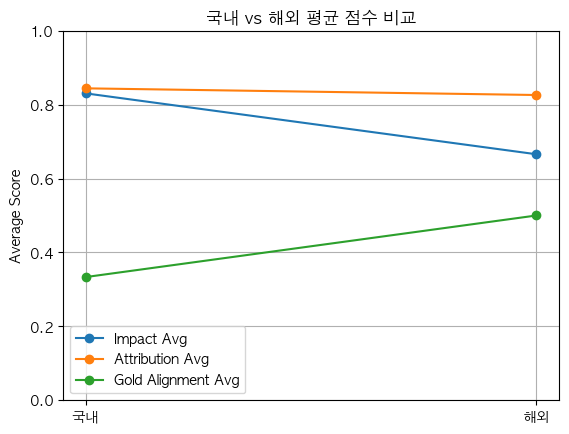

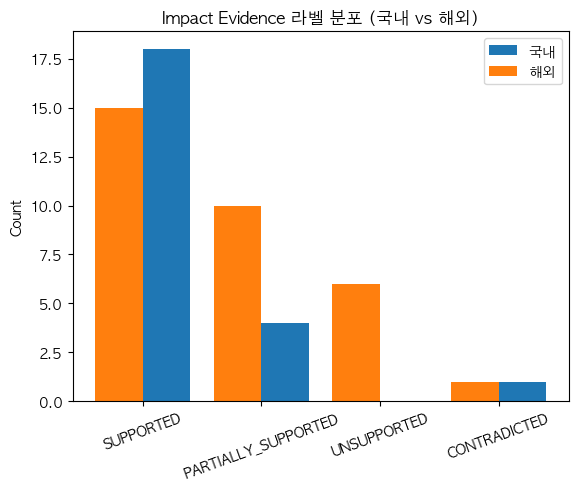

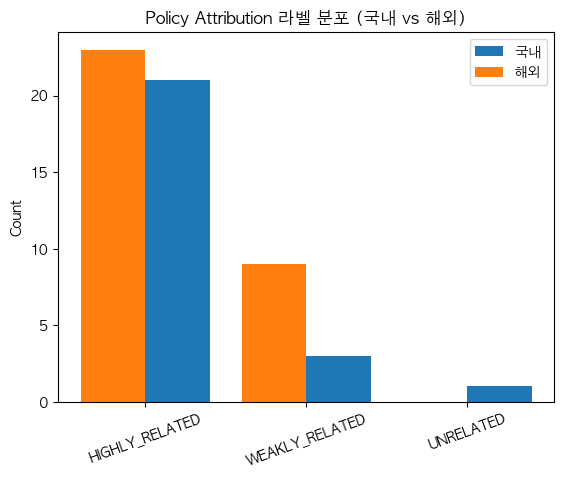

In [14]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'AppleGothic'
rcParams['axes.unicode_minus'] = False

# -----------------------------
# 1) 국내 vs 해외 평균 점수 비교
# -----------------------------
regions = ['domestic', 'foreign']
region_labels = ['국내', '해외']

impact_avgs = [result[r]['impact_avg'] for r in regions]
attr_avgs = [result[r]['attribution_avg'] for r in regions]
gold_avgs = [result[r]['gold_avg'] for r in regions]

x = range(len(regions))

plt.figure()
plt.plot(x, impact_avgs, marker='o', label='Impact Avg')
plt.plot(x, attr_avgs, marker='o', label='Attribution Avg')
plt.plot(x, gold_avgs, marker='o', label='Gold Alignment Avg')
plt.xticks(x, region_labels)
plt.ylim(0, 1)
plt.ylabel('Average Score')
plt.title('국내 vs 해외 평균 점수 비교')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 2) Impact Evidence 라벨 분포
# -----------------------------
impact_labels = ['SUPPORTED', 'PARTIALLY_SUPPORTED', 'UNSUPPORTED', 'CONTRADICTED']

dom_counts = [result['domestic']['impact_label_counts'].get(lbl, 0) for lbl in impact_labels]
for_counts = [result['foreign']['impact_label_counts'].get(lbl, 0) for lbl in impact_labels]

x = range(len(impact_labels))

plt.figure()
plt.bar(x, dom_counts, width=0.4, label='국내', align='edge')
plt.bar(x, for_counts, width=-0.4, label='해외', align='edge')
plt.xticks(x, impact_labels, rotation=20)
plt.ylabel('Count')
plt.title('Impact Evidence 라벨 분포 (국내 vs 해외)')
plt.legend()
plt.show()

# -----------------------------
# 3) Policy Attribution 라벨 분포
# -----------------------------
attr_labels = ['HIGHLY_RELATED', 'WEAKLY_RELATED', 'UNRELATED']

dom_attr_counts = [result['domestic']['attribution_label_counts'].get(lbl, 0) for lbl in attr_labels]
for_attr_counts = [result['foreign']['attribution_label_counts'].get(lbl, 0) for lbl in attr_labels]

x = range(len(attr_labels))

plt.figure()
plt.bar(x, dom_attr_counts, width=0.4, label='국내', align='edge')
plt.bar(x, for_attr_counts, width=-0.4, label='해외', align='edge')
plt.xticks(x, attr_labels, rotation=20)
plt.ylabel('Count')
plt.title('Policy Attribution 라벨 분포 (국내 vs 해외)')
plt.legend()
plt.show()


In [16]:
result

{'overall': {'impact_avg': 0.7345454545454544,
  'impact_label_counts': {'SUPPORTED': 33,
   'PARTIALLY_SUPPORTED': 14,
   'CONTRADICTED': 2,
   'UNSUPPORTED': 6},
  'attribution_avg': 0.8338596491228066,
  'attribution_label_counts': {'HIGHLY_RELATED': 44,
   'WEAKLY_RELATED': 12,
   'UNRELATED': 1},
  'gold_avg': 0.42105263157894735},
 'domestic': {'impact_avg': 0.8304347826086954,
  'impact_label_counts': {'SUPPORTED': 18,
   'PARTIALLY_SUPPORTED': 4,
   'CONTRADICTED': 1},
  'attribution_avg': 0.8439999999999999,
  'attribution_label_counts': {'HIGHLY_RELATED': 21,
   'WEAKLY_RELATED': 3,
   'UNRELATED': 1},
  'gold_avg': 0.3333333333333333},
 'foreign': {'impact_avg': 0.6656249999999998,
  'impact_label_counts': {'PARTIALLY_SUPPORTED': 10,
   'UNSUPPORTED': 6,
   'SUPPORTED': 15,
   'CONTRADICTED': 1},
  'attribution_avg': 0.8259374999999998,
  'attribution_label_counts': {'HIGHLY_RELATED': 23, 'WEAKLY_RELATED': 9},
  'gold_avg': 0.5}}

### 4. 평가 결과

#### 4.1 전체 성능 개요

딥리서치 평가 결과를 전체·국내·해외로 나누어 집계한 요약은 다음과 같습니다.

| 구분 | Impact Evidence 평균 | Policy Attribution 평균 | Gold Alignment 평균 |
| -- | ------------------ | --------------------- | ----------------- |
| 전체 | 0.73               | 0.83                  | 0.42              |
| 국내 | 0.83               | 0.84                  | 0.33              |
| 해외 | 0.67               | 0.83                  | 0.50              |

* **Impact Evidence Faithfulness**

  * 전체 평균 약 **0.73**으로, 기사 내용과 상당히 잘 맞는 영향 설명을 생성하고 있습니다.   
  * 특히 **국내(0.83)**가 해외(0.67)보다 더 근거에 충실한 경향을 보입니다.   

* **Policy Attribution Consistency**
  * 국내/해외 모두 **0.82–0.84**정도이며, 이는 정치인·정책과 실제 기사 간 **관련성 있는 근거 기사 선택**은 전반적으로 잘 이루어지고 있다는 것을 의미합니다.   

* **Gold Report Alignment**

  * 전체 평균은 약 **0.42**로, Gold 리포트와 내용·구조 유사도가 아주 높지는 않은 편입니다.
  * 국내(0.33)보다 해외(0.50)가 더 높은데, 이는

    * 해외 세트의 경우 국내처럼 Naver 맞춤형 검색·스크래핑 파이프라인이 아니라, 상대적으로 단순한 검색 툴과 소수의 대표 기사에 의존하는 경향이 있어 Gold 리포트와 모델 리포트가 참고하는 기사·키워드 풀이 더 많이 겹쳤을 가능성이 있습니다.  
      그 결과, 실제 근거 충실성은 국내보다 다소 낮더라도 **Gold와의 내용·구조 유사도는 해외 쪽에서 더 높게 측정된 것**으로 해석할 수 있습니다.  
      다만, 이는 현재 평가셋과 검색 파이프라인 구조에 기반한 추정이며, 향후 URL·정책 키워드·기업명 중복률 등을 추가로 분석해 검증할 필요가 있습니다.

---





#### 4.2 라벨 분포 분석

**Impact Evidence 라벨 분포**

* 전체:

  * `SUPPORTED` 33, `PARTIALLY_SUPPORTED` 14, `UNSUPPORTED` 6, `CONTRADICTED` 2
* 국내:

  * `SUPPORTED` 18, `PARTIALLY_SUPPORTED` 4, `CONTRADICTED` 1, `UNSUPPORTED` 0
* 해외:

  * `SUPPORTED` 15, `PARTIALLY_SUPPORTED` 10, `UNSUPPORTED` 6, `CONTRADICTED` 1


* 국내 체인은 **SUPPORTED 비율이 높고 UNSUPPORTED가 거의 없음**
  → 국내 정치인에 대해서는 기사 근거에 잘 맞는 영향 설명을 생성하고 있습니다.  
  특히 국내 셋은 **Naver 맞춤형 검색·스크래핑 툴을 사용해 정책·산업 관련 기사를 수집**했기 때문에,
  모델이 참고하는 증거 풀이 더 풍부하고 정밀했고, 이 점이 높은 SUPPORTED 비율로 이어진 것으로 해석할 수 있습니다.


* 해외 체인은 **PARTIALLY_SUPPORTED·UNSUPPORTED 비율이 국내보다 더 높음**
  → 해외의 경우 여러 기사에서 정보를 종합하는 과정에서  
    * 일부 세부 내용이 기사에 명확히 나오지 않거나  
    * 기사에 없는 내용을 추론으로 보완하면서, 근거가 약한 주장도 함께 생성되는 경향이 있습니다.  

  또한 해외 셋은 국내처럼 **Naver 특화 검색·스크래핑 툴에서, 상대적으로 검색되는 기사의 양이 적기** 때문에
  * 정책·산업 맥락을 충분히 커버하는 기사 풀이 상대적으로 제한적이었고,
  * 이로 인해 모델이 **증거가 비어 있는 부분을 추론으로 메우는 비율**이 높아져  
    PARTIALLY_SUPPORTED·UNSUPPORTED 라벨 비중이 국내 대비 더 커진 것으로 해석할 수 있습니다.


**Policy Attribution 라벨 분포**

* 전체:

  * `HIGHLY_RELATED` 44, `WEAKLY_RELATED` 12, `UNRELATED` 1
* 국내:

  * `HIGHLY_RELATED` 21, `WEAKLY_RELATED` 3, `UNRELATED` 1
* 해외:

  * `HIGHLY_RELATED` 23, `WEAKLY_RELATED` 9, `UNRELATED` 0


* 국내·해외 공통적으로 **대부분의 URL이 HIGHLY_RELATED**로 평가됩니다.
  → 검색/증거 선택 단계에서 **정치인·정책과 직접적으로 관련된 기사들**을 잘 가져오고 있습니다.   
* `UNRELATED`는 국내에서 1건, 해외는 0건으로 매우 낮음
  → “정책과 거의 관계 없는 기사”를 근거로 끌어오는 경우는 드뭅니다.

---

#### 4.3 종합 해석

* **검색 품질(Relevance)**

  * Policy Attribution 점수와 라벨 분포를 보면,
    → 국내·해외 모두 **정치인–정책과 강하게 연관된 기사들을 중심으로 증거를 선택**하고 있습니다.

* **근거 충실성(Faithfulness)**

  * 국내는 대부분 `SUPPORTED`로, 기사에 기반한 영향 설명이 잘 생성됩니다.
  * 해외는 `PARTIALLY_SUPPORTED`·`UNSUPPORTED`가 더 많아,
    → **기사에 없는 세부 주장**이 섞이는 할루시네이션 위험이 상대적으로 더 큽니다.

* **분석 스타일 정합성(Gold Alignment)**

  * Gold와의 유사도는 중간 수준으로,

    * 딥리서치 시스템이 Gold와 동일한 분석을 그대로 복제한다기보다는,
    * **자체적인 체인 구성과 서술을 갖는 리포트**를 생성하고 있다고 볼 수 있습니다.

